參考範例：
https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


# 這樣寫就不用隨著是否有GPU去一行一行改.cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Read data
用transforms.ToTensor()，會自動標準化至[0,1]，且RGB不會跑掉<br>
pytorch的channel在最前面，Image轉numpy之後的channel在最後面<br>
所以如果要用Image轉numpy，要再transpose(2,0,1)

In [3]:
IMAGE_SIZE = 100

data = np.empty((10000, 3, IMAGE_SIZE*IMAGE_SIZE))
l = os.listdir('cartoon/cartoon/')

for i,j  in enumerate(l):
    im = Image.open('cartoon/cartoon/'+j).convert('RGB').resize((IMAGE_SIZE,IMAGE_SIZE))
#     im = Image.open('animation/animation/'+j).convert('RGB').resize((IMAGE_SIZE,IMAGE_SIZE))
    im = transforms.ToTensor()(im)
    data[i,...] = im.numpy().reshape(3, IMAGE_SIZE*IMAGE_SIZE)
print (data.shape)

(10000, 3, 10000)


In [4]:
import torch.utils.data as Data

BATCH_SIZE = 100
torch_data = Data.TensorDataset(torch.from_numpy(data.reshape(10000,-1)).type(torch.FloatTensor))
data_loader = torch.utils.data.DataLoader(dataset=torch_data,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)
for i, (x) in enumerate(data_loader):
    print (x[0].shape)
    if i==0:
        break

torch.Size([100, 30000])


# VAE Model

In [5]:
H_DIM_1 = 400
H_DIM_2 = 200
Z_DIM = 25

class VAE(nn.Module):
    def __init__(self, image_size=IMAGE_SIZE, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, z_dim=Z_DIM):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size*image_size*3, h_dim_1)
        self.fc2 = nn.Linear(h_dim_1, h_dim_2)
        self.fc3 = nn.Linear(h_dim_2, z_dim)
        self.fc4 = nn.Linear(h_dim_2, z_dim)
        self.fc5 = nn.Linear(z_dim, h_dim_2)
        self.fc6 = nn.Linear(h_dim_2, h_dim_1)
        self.fc7 = nn.Linear(h_dim_1, image_size*image_size*3)
        
    def encode(self, x):
        x = F.relu(self.fc1(x))
        h = F.relu(self.fc2(x))
        return self.fc3(h), self.fc4(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std) # noise
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.fc5(z))
        h = F.relu(self.fc6(z))
        return torch.sigmoid(self.fc7(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [6]:
import time
start_time = time.time()

EPOCHS = 100
LR = 1e-3

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

loss_re, loss_kl = [],[]
for epoch in range(EPOCHS):
    for i, (x) in enumerate(data_loader):
        # Forward pass
        x = x[0].to(device) # 要用x[0]，而非x，因為此處的dataloader沒有Y  # .view(-1, IMAGE_SIZE*IMAGE_SIZE*3)
        x_reconst, mu, log_var = model(x)
        
        # Loss
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backpropagation
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_re.append(reconst_loss.item())
        loss_kl.append(kl_div.item())
    print ("Epoch[{}/{}], Reconst Loss: {:.3f}, KL Div: {:.3f}" 
                   .format(epoch+1, EPOCHS, reconst_loss.item(), kl_div.item()))
    with torch.no_grad():
        #  生成圖片
        z = torch.randn(64, Z_DIM).to(device) # 生64張
        out_sample = model.decode(z).view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)
        save_image(out_sample, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # 觀察重構圖片的狀況
        out_recon, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 3, IMAGE_SIZE, IMAGE_SIZE), out_recon.view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

elapsed_time = time.time() - start_time
print ('\nTime：',time.strftime("%M:%S", time.gmtime(elapsed_time)))

Epoch[1/100], Reconst Loss: 569871.438, KL Div: 8307.731
Epoch[2/100], Reconst Loss: 569258.875, KL Div: 4043.912
Epoch[3/100], Reconst Loss: 524459.125, KL Div: 5009.643
Epoch[4/100], Reconst Loss: 505113.750, KL Div: 4466.801
Epoch[5/100], Reconst Loss: 492463.719, KL Div: 5008.455
Epoch[6/100], Reconst Loss: 455425.469, KL Div: 5562.251
Epoch[7/100], Reconst Loss: 460917.312, KL Div: 5444.320
Epoch[8/100], Reconst Loss: 447411.281, KL Div: 5743.154
Epoch[9/100], Reconst Loss: 456955.406, KL Div: 5697.915
Epoch[10/100], Reconst Loss: 437115.969, KL Div: 5799.436
Epoch[11/100], Reconst Loss: 428576.969, KL Div: 5917.128
Epoch[12/100], Reconst Loss: 438396.844, KL Div: 5726.045
Epoch[13/100], Reconst Loss: 418798.438, KL Div: 5900.393
Epoch[14/100], Reconst Loss: 402610.281, KL Div: 5665.965
Epoch[15/100], Reconst Loss: 450950.812, KL Div: 5625.259
Epoch[16/100], Reconst Loss: 407045.531, KL Div: 5545.037
Epoch[17/100], Reconst Loss: 415364.812, KL Div: 5827.792
Epoch[18/100], Reconst 

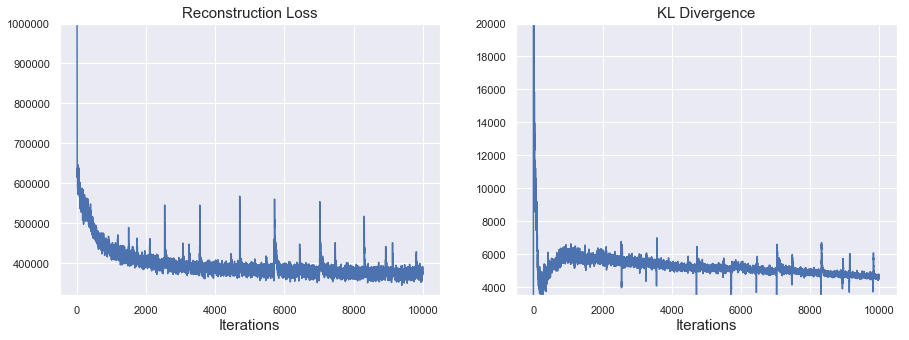

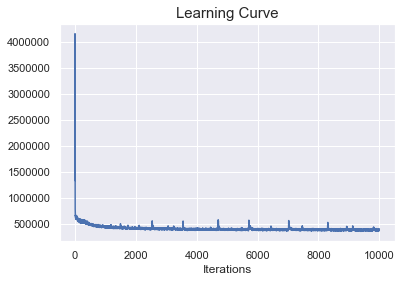

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.lineplot(range(len(loss_re)), loss_re, ax=ax1)
ax1.set_title('Reconstruction Loss',fontsize=15)
ax1.set_xlabel('Iterations',fontsize=15)
ax1.set_ylim(320000,1000000)

sns.lineplot(range(len(loss_kl)), loss_kl, ax=ax2)
ax2.set_title('KL Divergence',fontsize=15)
ax2.set_xlabel('Iterations',fontsize=15)
ax2.set_ylim(3500,20000)
plt.show()

sns.lineplot(range(len(loss_re)), np.array(loss_re)+np.array(loss_kl))
plt.title('Learning Curve', fontsize=15)
plt.xlabel('Iterations')
plt.show()

# Visualize Samples

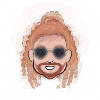

In [8]:
transforms.ToPILImage()(out_sample[10].reshape(3,IMAGE_SIZE,IMAGE_SIZE).cpu())